<img align="center" src="https://raw.githubusercontent.com/FUlyankin/Parsers/master/images%20/cats.jpg" height="1200" width="1200"> 

# Домашка 6: классификация

Давайте попрбобуем построить модель, предсказывающую пол пользователя

In [1]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже смутно знакомый вам пакет для картинок :3
import matplotlib
import seaborn as sns             # ещё один пакет для картинок 
plt.style.use('ggplot')     # правильный (очень красивый) стиль у графиков

%matplotlib inline

In [2]:
# Метрики для измерения качества алгоритмов 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [3]:
# Импортируем то, что понадобится для выполнения заданий
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
import itertools

# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass

# 1. Снова подгружаем данные

В очередной раз подгрузим немного данных. 

In [5]:
df = pd.read_csv('../data/vk_download/vk_main.csv', sep='\t')   # подгружаем датасет
df.head()

,city,country,first_name,home_town,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Москва,Россия,Александра,Москва,True,True,False,Абашкова,60.0,182152789,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,42.0,0.428571
1,Рязань,Россия,Анастасия,Рязань,True,True,False,Чуфистова,0.0,148020433,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,32.0,0.281250
2,Москва,Россия,Александр,Омск,False,True,False,Головачев,0.0,138413935,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,32.0,0.406250
3,NaN,NaN,Анна,NaN,False,True,False,Лобанова,0.0,366261055,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,45.0,0.333333
4,NaN,Россия,Алексей,NaN,True,True,False,Пузырный,21.0,111252392,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,41.0,0.341463


In [6]:
df.columns

Index(['city', 'country', 'first_name', 'home_town', 'in_hse_memes_group',
       'is_bmm', 'is_closed', 'last_name', 'likes_memes', 'uid', 'male_dummy',
       'facebook_dummy', 'instagram_dummy', 'skype_dummy', 'twitter_dummy',
       'home_phone_dummy', 'mobile_phone_dummy', 'site_dummy',
       'can_post_dummy', 'can_see_all_posts_dummy', 'can_see_audio_dummy',
       'can_write_private_message_dummy', 'has_mobile_dummy', 'has_ava_dummy',
       'wall_comments_dummy', 'english_dummy', 'folowers_cnt', 'albums_cnt',
       'audio_cnt', 'followers_cnt', 'friends_cnt', 'gifts_cnt', 'groups_cnt',
       'photos_cnt', 'subscriptions_cnt', 'user_photos_cnt', 'videos_cnt',
       'pages_cnt', 'lang_cnt', 'change_city_school_cnt', 'schools_cnt',
       'relation_cat', 'alco_love_cat', 'smoke_love_cat', 'life_main_cat',
       'people_main_cat', 'political_cat', 'private_prof_dummy',
       'wall_can_comment_dummy', 'wall_comment_cnt', 'wall_comment_max',
       'wall_comment_mean', 'wall_co

Ровно также, как мы это делали на семинаре, предобработаем данные. Если вы не понимаете какую-то из строчек в следущем большом кодище, выясните как она работает. Напишите в чат тех-поддержки, семинаристу, сходите к гадалке. Сделайте хоть что-то, потому что скоро такой код вам придётся писать самостоятельно. 

In [7]:
# выбрасываем из выборки все переменные, в которых слишком много пропусков
isnull = df.isnull().sum()
df = df[isnull[isnull <= 56].index]

# Выборка с переменными-счётчиками
variables_cnt = [item for item in df.columns if item[-3:] == 'cnt']

# Оставляем только информативные переменные (картинки можно посмотреть в семинарской тетрадке)
variables_cnt = [item for item in variables_cnt if len(df[item].unique()) > 10]

# логарифмируем счётчики
df[variables_cnt] = df[variables_cnt].apply(lambda w: np.log(w + 1))

# отбираем дамми - переменные в том числе наш указатель пола
variables_dummy = [item for item in df.columns if item[-5:] == 'dummy']

# средние, медианы и максимумы
variables_mean = [item for item in df.columns if item[-4:] == 'mean']
variables_median = [item for item in df.columns if item[-6:] == 'median']
variables_max = [item for item in df.columns if item[-3:] == 'max']

# все полезные переменные
useful_variables = variables_cnt + variables_dummy + variables_mean + \
                   variables_median + variables_max + ['friends_mail_from_course_pct']

# заполняем пропуски нулями
df[useful_variables] = df[useful_variables].fillna(0)
df.head()

,first_name,in_hse_memes_group,is_bmm,is_closed,last_name,likes_memes,uid,male_dummy,facebook_dummy,instagram_dummy,...,photo_month_mean,photo_repost_cnt,photo_repost_max,photo_repost_mean,photo_repost_median,photo_text_len_cnt,photo_ava_change_cnt,photo_text_url_len_cnt,friends_from_course_cnt,friends_mail_from_course_pct
0,Александра,True,True,False,Абашкова,60.0,182152789,0,0,1,...,1.333333,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.761200,0.428571
1,Анастасия,True,True,False,Чуфистова,0.0,148020433,0,0,0,...,2.375000,2.0,1.0,0.105263,0.0,0.0,0.0,0.0,3.496508,0.281250
2,Александр,False,True,False,Головачев,0.0,138413935,1,0,1,...,1.400000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.496508,0.406250
3,Анна,False,True,False,Лобанова,0.0,366261055,0,0,0,...,4.166667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.828641,0.333333
4,Алексей,True,True,False,Пузырный,21.0,111252392,1,0,0,...,3.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.737670,0.341463


# 2. Подготовка к моделированию.

Начнём с простого. 

__[1]__ Разделите выборку на тренировочную и тестовую. Запишите обучающую выборку в табличку `df_train`, а тестовую в `df_test`.

In [8]:
df_train, df_test = train_test_split(df, random_state=0)

Для удобства запишем в `y` то, что мы хотим прогнозировать.

In [9]:
y_train = df_train['male_dummy'].to_numpy()
y_test = df_test['male_dummy'].to_numpy()

Посмотрим как соотносятся доли парней и девушек в тренировочной и тестовой выборках.

In [10]:
np.mean(y_train), np.mean(y_test)

(0.4779874213836478, 0.40186915887850466)

В `X` запишем то, по чему мы будем прогнозировать. 

In [11]:
# Забираем в выборку лучших из лучших 
X_train = df_train[useful_variables].drop('male_dummy', axis=1).to_numpy()
X_test = df_test[useful_variables].drop('male_dummy', axis=1).to_numpy()

# 3. Метод ближайшего соседа

Начнём моделирование с метода ближайшего соседа. 

__[1]__ Проскалируйте переменные. Поясните в виде текста зачем нужно это делать. Надо ли скалировать переменные для деревьев? 

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Это преобразование необходимо для того, чтобы линейные, или основанные на расстоянии алгоритмы лучше сходились. Например, если у одной переменной диапазон [0, 100000], а у другой - [0, 1], то, например, метод KNN будет очень плохо работать с таким датасетом. <br/>
Для деревьев переменные можно не скалировать

__[1]__ Обучите на тренировочной выборке алгоритм 10 ближайших соседей. Запишите прогнозы алгоритма в переменную `y_predict`.

In [13]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

Построим для получившегося алгоритма roc-кривую на тестовой выборке. 

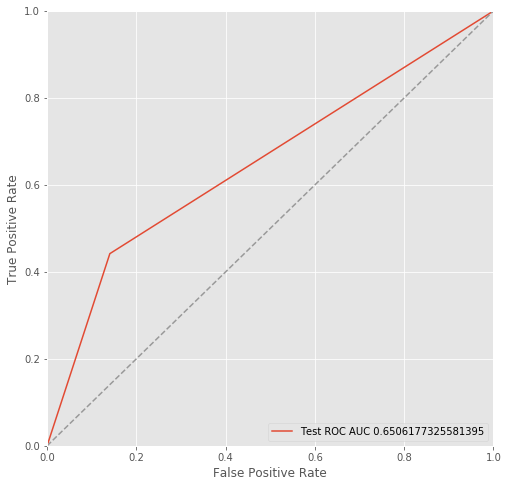

In [14]:
roc_auc_pic(y_predict, y_test)

Посмотрим какой получилось accuracy (доля правильных ответов). 

In [15]:
accuracy_score(y_test, y_predict)

0.6915887850467289

__[1]__ Какой вывод о прогнозной силе алгоритма вы можете сделать? Можно ли в данной ситуации в качестве метрики использовать `acuracy`? 

__Ответ:__ В целом, алгоритм предсказывает лучше, чем если просто всегда предсказывать самый популярный класс, хотя можно было и лучше. Так как классы практически сбалансированны(47% на train, 40% на test), то accuracy тут, в целом, можно использовать, и отличие между roc auc и accuracy, как мы видим, не очень большое

# 4. Пытаемся улучшить работу алгоритма

Давайте попытаемся выжать из метода ближайших соседей максимум. 

__[2]__ Попробуйте перебрать разное количество соседей и разные дистанции. Насколько получилось улучшить работу классификатора? 

In [17]:
grid_knn = GridSearchCV(KNeighborsClassifier(), {'n_neighbors': range(1, 50), 'p': range(1, 6)}, n_jobs=-1,
                       cv=5)
grid_knn.fit(X_train, y_train)

/home/feodosii/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 50), 'p': range(1, 6)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Какое сочетания параметров оказалось оптимальным? Какое качество показывает алгоритм? 

In [18]:
grid_knn.best_score_

0.6540880503144654

In [19]:
grid_knn.best_params_

{'n_neighbors': 17, 'p': 1}

Посмотрим метрики на test

In [20]:
y_predict = grid_knn.predict(X_test)

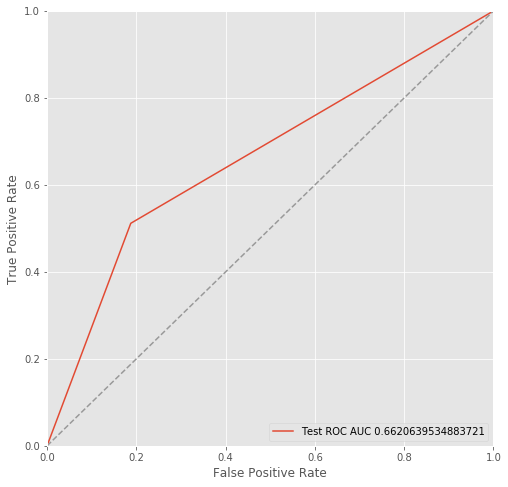

In [21]:
roc_auc_pic(y_predict, y_test)

In [22]:
accuracy_score(y_test, y_predict)

0.6915887850467289

Видно, что на тесте новая модель справилась лучше по roc-auc, по accuracy примерно то же самое значение.

# 5. Дерево 

__[2]__ Продолжаем наше путешествие в классификацию. Постройте решающее дерево. Какое качество оно показывает на тренировочной выборке? А на тестовой? Что такое переобучение? Правда ли, что дерево переобучилось? 

In [23]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

In [24]:
print(f'''
Roc-auc на train: {roc_auc_score(predicted_train, y_train)}
Accuracy на train: {accuracy_score(predicted_train, y_train)}

Roc-auc на test: {roc_auc_score(predicted_test, y_test)}
Accuracy на test: {accuracy_score(predicted_test, y_test)}
''')


Roc-auc на train: 1.0
Accuracy на train: 1.0

Roc-auc на test: 0.6781083142639206
Accuracy на test: 0.6915887850467289



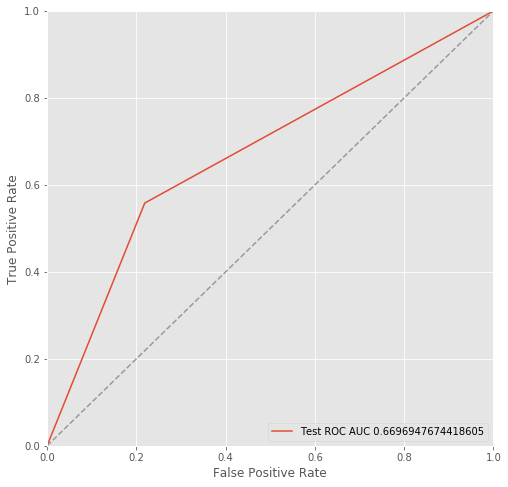

In [25]:
roc_auc_pic(predicted_test, y_test)

__Ответ:__ Переобучение происходит, когда модель слишком хорошо запоминает данные, которые были в тренировочной выборке и за счет этого теряет возможность обобщать. Да, дерево переобучилось

# 6. Случайный лес 

__[2]__ Попробуйте обучить случайный лес, посмотрите на качество его работы по метрике roc_auc. 

In [35]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted_train = model.predict(X_train)
predicted_test = model.predict(X_test)

/home/feodosii/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [36]:
print(f'''
Roc-auc на train: {roc_auc_score(predicted_train, y_train)}
Accuracy на train: {accuracy_score(predicted_train, y_train)}

Roc-auc на test: {roc_auc_score(predicted_test, y_test)}
Accuracy на test: {accuracy_score(predicted_test, y_test)}
''')


Roc-auc на train: 0.9825581395348838
Accuracy на train: 0.9811320754716981

Roc-auc на test: 0.7093189964157706
Accuracy на test: 0.719626168224299



* Зачем деревья объединяют в лес? 

__Ответ:__ Чтобы было меньше переобучение 

* Какой из трёх обученных выше алгоритмов показал наилучшее качество? 

__Ответ:__ Случайный лес

* Как считате, удалось ли нам научиться предсказывать, что студент первого курса поставит в паблик лайк? С чем это на ваш взгляд связано? 

__Ответ:__ Скорее получилось. Результат в 70% лучше чем, например, случайное угадывание и предсказание самого частого класса


Свои возмущение и ненависть, либо любовь и обожание можно оставить в [Анонимке по 6 домашке](https://docs.google.com/forms/d/e/1FAIpQLSeKVcEfJqBD4XpDclz6QnAGb5QInQ2843iAuSneVtbBkBaL5Q/viewform)